# Tdsm encoder (Toy Model)
This section is made for quickly experimenting new idea and getting understand the whole structure. Working on SWAN is recommanded. You can utilize GPU by entering the node [SWAN](https://swan-k8s.cern.ch) and choose `Software stack=102b Cuda 11.7.1(GPU)` to configure environment(Probably need to open the ticket to get the access).

## Import module

In [1]:
import time, functools, torch, os, random, utils, fnmatch, psutil, argparse
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nnz
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from trans_tdsm import Gen, loss_fn, pc_sampler
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D

## Configuration

In [2]:
workingdir = "./"
print('torch version: ', torch.__version__)
global device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)


torch version:  1.11.0a0+gitbc2c6ed
Running on device:  cuda
Cuda used to build pyTorch:  11.7
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./


## Generate Toy Model (Option)
Generate toy events. The result will be stored in `dataset/toy_model.pt`. The result is in the form of [List(Events(torch.tensor(max_hit, nfeatures)), injection energy(1D torch.tensor)].

In [3]:
from toy_generator import generate_event
result = generate_event(max_energy=200, nevent=20000, nlayer=5)
print("max number of hits", result[0][0].shape[0])
print("nfeatures", result[0][0].shape[1])
print("nEvents", result[1].shape[0])

max number of hits 150
nfeatures 4
nEvents 20000


## Demonstrate Event (Option)

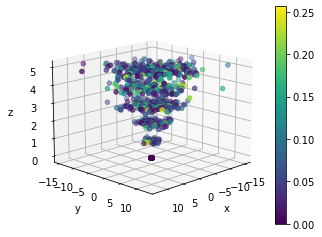

In [4]:
from display_result import display_result
display_result(nevent=10)

## Load dataset (Try until it works)
SWAN seems to easily fail to load dataset to GPU, so need to run this cell several times until it succeeds. Experience shows O(3~4) times is needed.

In [6]:
# You may need to run several times until it succeeds.
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

vesde = utils.VESDE(device=device)
batch_size = 150

new_marginal_prob_std_fn = functools.partial(vesde.marginal_prob)
new_diffusion_coeff_fn   = functools.partial(vesde.sde)

training_file_path = 'dataset/toy_model.pt'
filename = training_file_path
loaded_file = torch.load(filename, map_location=torch.device(device))

inject_energy = loaded_file[1]
events        = loaded_file[0]

training_dataset = events[:10000]
training_inject_energy = inject_energy[:10000]
testing_dataset  = events[10000:]
testing_inject_energy  = inject_energy[10000:]

dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)

## Summarize training samples

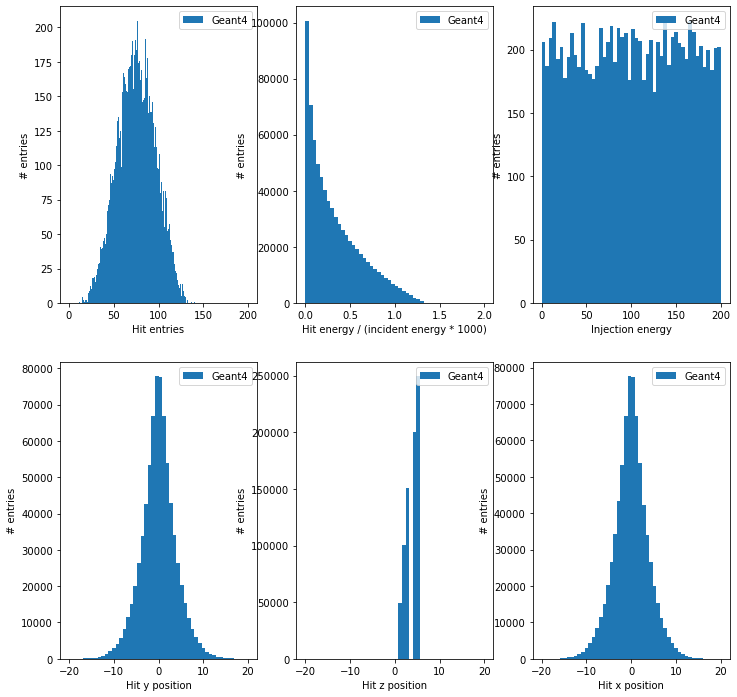

In [7]:
from display_result import summarize_result
summarize_result(training_dataset, training_inject_energy, threshold=0.5, label = "Geant4")

## Training

  0%|          | 0/200 [00:00<?, ?it/s]

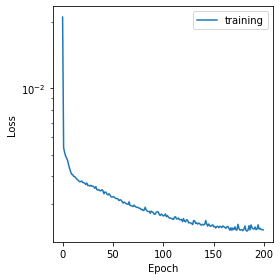

<Figure size 432x288 with 0 Axes>

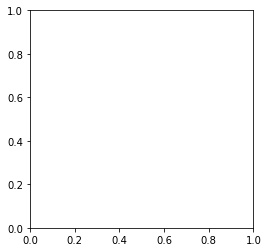

In [12]:
import tqdm
from IPython import display
%matplotlib inline
plt.gcf().canvas.draw()

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
output_directory = os.path.join(workingdir, 'training_result')
os.system(f'mkdir -p {output_directory}')

lr = 0.0001
n_epochs = 200

model = Gen(4, 200, 128, 3, 1, 0, marginal_prob_std=new_marginal_prob_std_fn)

#print('model: ', model)

optimiser = Adam(model.parameters(), lr=lr)

av_losses_per_epoch = []
tqdm_epoch = tqdm.notebook.trange(n_epochs)

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
dh = display.display(fig, display_id=True)

for epoch in tqdm_epoch:
#    print(f"epoch: {epoch}")
    batch_losses = []
    batch_counter = 0
    cloud_counter = 0
    cumulative_epoch_loss = 0

    process = psutil.Process(os.getpid())
#    print('Memory usage of current python process: ', process.memory_info().rss)
    index = 0
    for i, data in enumerate(dataloader,0):
        incident_energies = training_inject_energy[i*batch_size: i*batch_size+len(data)]
        batch_loss = loss_fn(model, data, incident_energies, new_marginal_prob_std_fn, device=device)
        batch_counter += 1
        cloud_counter += len(data)
#        print(f'Batch{batch_counter}: loss average: ', batch_loss.item()/len(data))
        optimiser.zero_grad()
        batch_loss.backward(retain_graph=True)
        cumulative_epoch_loss += batch_loss.item()
        optimiser.step()

    av_losses_per_epoch.append(cumulative_epoch_loss/cloud_counter)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(cumulative_epoch_loss/cloud_counter))
    # Save checkpoint file after each epoch
    torch.save(model.state_dict(), os.path.join(output_directory,'ckpt_tmp_selfattn_'+str(epoch)+'.pth'))

    fig, ax = plt.subplots(ncols=1, figsize=(4,4))
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
    plt.plot(av_losses_per_epoch, label='training')
    plt.legend(loc='upper right')
    plt.tight_layout()
    dh.update(fig)
    plt.close(fig)
    #fig.savefig(os.path.join(output_directory, 'loss_v_epoch.png'))

## Testing (Generate events)

In [24]:
output_directory = os.path.join(workingdir, 'sampling')
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

load_name = '/eos/user/t/tihsu/SWAN_projects/ML_hackathon/toy_model/training_result/ckpt_tmp_selfattn_199.pth'
sample_batch_size = 2000
model = Gen(4, 200, 128, 3, 1, 0, marginal_prob_std=new_marginal_prob_std_fn)
model.load_state_dict(torch.load(load_name, map_location=device))
model.to(device)
in_energies = []

hits_lengths = []
sampled_energies = testing_inject_energy[:sample_batch_size]
sampled_hits = torch.ones(sample_batch_size)*(testing_dataset[0].shape[0])
samples = pc_sampler(model, new_marginal_prob_std_fn, new_diffusion_coeff_fn, sampled_energies, sampled_hits, sample_batch_size, device=device)
torch.save(samples, os.path.join(output_directory,'generated_samples.pt'))

## Summarize Generated events
Note that when generating event, we always generates with fixed nhits (maximum nhit). Since we do not mask zero-padding in training, the model should learn the information of zero-padding. Thus, by putting some threshold on z, we can identify which hits is redundant and drop it.

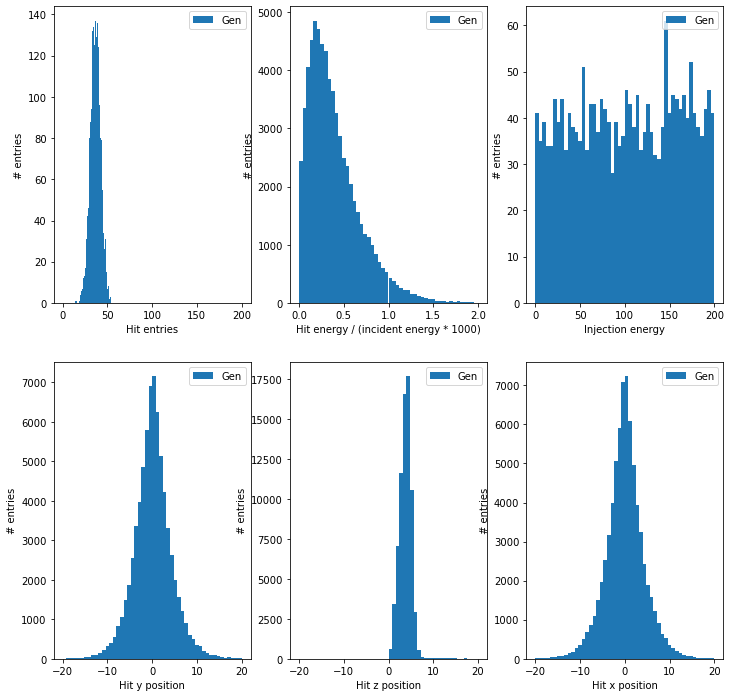

In [14]:
from display_result import summarize_result
summarize_result(samples, sampled_energies, threshold=0.5, label = "Gen")